backdoor attack:  False
poisoned data portion in each client:  0.5
target label:  0
comprised_client_idx:  range(0, 20)
read_dir:  ~/processed_data/FashionMNIST_iid-True_numclients-20_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/
clients_label_numbers_2D_list:  [[300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300], [300, 300, 300, 300, 300, 300, 300, 300,

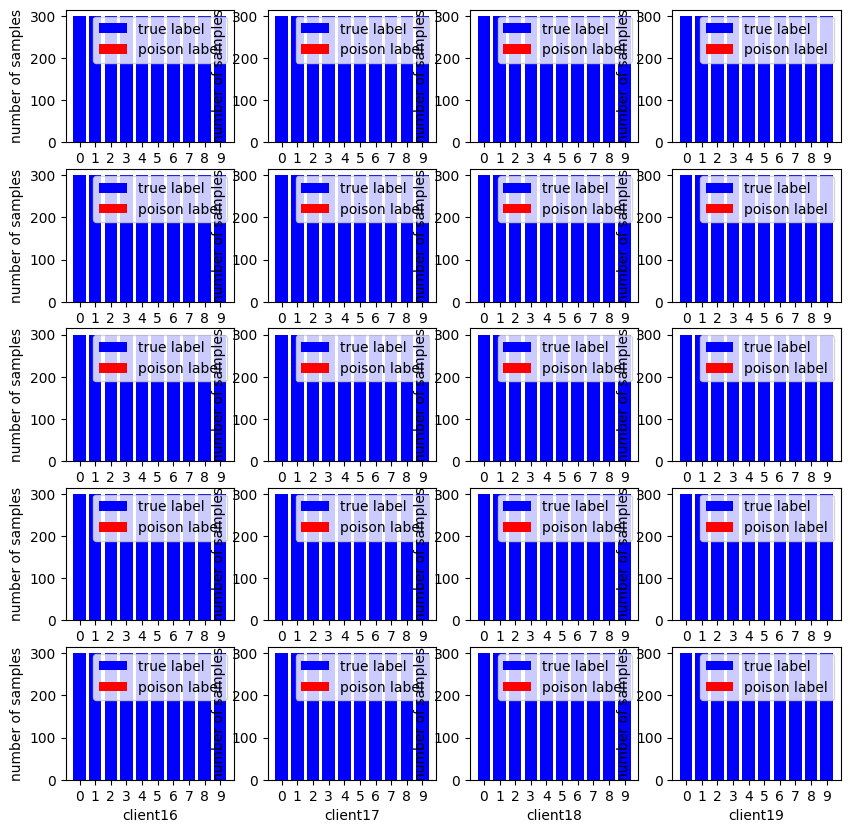

In [360]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import random
import os
import copy
from tqdm import tqdm
from matplotlib import pyplot as plt



# ================================== 参数设置 ====================================   
# 选择数据集
dataset_name = 'MNIST'
# dataset_name = 'FashionMNIST'
# dataset_name = 'CIFAR10'

# attack_method = 'SignFlipping'
# attack_method = 'LabelFlipping'
# attack_method = 'Noise-(0,1)'

# attack_method = 'IPM-0.1'
# attack_method = 'IPM-100'
# attack_method = 'Backdoor'
# attack_method = 'NoAttack'
attack_method = 'ALIE'
# attack_method = 'MinMax'

# 攻击类型限制范围
attack_methods = ['LabelFlipping', 'SignFlipping', 'Noise-(0,1)', 'ALIE', 'MinMax', 'IPM-0.1', 'IPM-100', 'Backdoor', 'NoAttack']
assert attack_method in attack_methods, "attack_method should be one of {}".format(attack_methods)

if attack_method == 'Backdoor':
    backdoor = True
else:
    backdoor = False
print("backdoor attack: ", backdoor)

# poisioned client portion
poisoned_client_portion = 0.4

# poisioned data portion
poison_data_portion = 0.5
print("poisoned data portion in each client: ", poison_data_portion)

# target label
target_label = 0
print("target label: ", target_label)

# 设置数据集的超参数
num_clients = 20
num_classes = 10


iid = True

# iid = False
alpha = 0.1

# 被comprised的客户端的index
comprised_client_idx = range(num_clients)
print("comprised_client_idx: ", comprised_client_idx)




# ===============================================================

# 生成保存目录的函数
def get_processed_data_dir(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion):
    if iid == True:
        data_dir = '~/processed_data/{}_iid-{}_numclients-{}_backdoor-{}_poisonedclientsportion-{}_poisoneddataportion-{}/'.format(dataset_name, iid, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
    else:
        data_dir = '~/processed_data/{}_iid-{}_alpha-{}_numclients-{}_backdoor-{}_poisonedclientsportion-{}_poisoneddataportion-{}/'.format(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
    return data_dir

# 读取数据所在的目录
read_dir = get_processed_data_dir(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
print("read_dir: ", read_dir)

import os
# 扩展波浪号到用户主目录
read_dir = os.path.expanduser(read_dir)
# 检查目录是否存在, 不存在则发出警告
if not os.path.exists(read_dir):
    print("Warning: the directory does not exist!")

# 读取每个客户端的数据
def load_multiple_client_training_data(num_clients, read_dir):
    clients_images_list = [[] for _ in range(num_clients)]
    clients_labels_list = [[] for _ in range(num_clients)]
    clients_modified_labels_list = [[] for _ in range(num_clients)]
    for i in range(num_clients):
        data = np.load(read_dir + 'client{}_data.npz'.format(i))
        clients_images_list[i] = data['images']
        clients_labels_list[i] = data['labels']
        clients_modified_labels_list[i] = data['modified_labels']
    test_data = np.load(read_dir + 'test_data.npz')
    test_images = test_data['images']
    test_labels = test_data['labels']
    return clients_images_list, clients_labels_list, clients_modified_labels_list, test_images, test_labels
clients_images_numpuy_list, clients_labels_list, clients_modified_labels_list, test_images, test_labels = load_multiple_client_training_data(num_clients, read_dir)

# clients_labels_list[i][j] 表示第i个客户端的第j个样本(不是按类别的)的标签
"""
np.where(arr > 5) 返回一个元组，其中每个元素是一个数组，表示满足条件的元素的索引。对于一维数组，元组中只有一个元素。
np.where(arr > 5)[0] 直接返回元组中的第一个元素，即索引数组本身。
"""
# 统计每个客户端的每个样本的标签数量, 并画图
def get_statistic_of_dataset(clients_labels_list, clients_modified_labels_list, num_clients, num_classes):
    # 每个客户端每个类别的idx
    clients_label_numbers_2D_list = [[0 for _ in range(num_classes)] for _ in range(num_clients)]
    
    # 每个客户端每个类别被投毒的数量
    clients_poison_label_numbers_2D_list = [[0 for _ in range(num_classes)] for _ in range(num_clients)]
    

    for i in range(num_clients):
        for j in range(num_classes):
            # 客户端i中真实类别为j的 样本index
            index_i_true_j = np.where(clients_labels_list[i] == j)[0]
            clients_label_numbers_2D_list[i][j] = len(index_i_true_j)
            # 进一步检查是否被投毒, index_i_true_j中的 clients_modified_labels_list[i][index_i_true_j] != j 的index记作index_i_poison_j
            index_i_poison_j = np.where(clients_modified_labels_list[i][index_i_true_j] != j)[0]
            clients_poison_label_numbers_2D_list[i][j] = len(index_i_poison_j)
            
    print("clients_label_numbers_2D_list: ", clients_label_numbers_2D_list)
    print("clients_poison_label_numbers_2D_list: ", clients_poison_label_numbers_2D_list)
    # 画图, 在同一张图上同时画出每个客户端每个样本的数量的散点图, 每个客户端每个样本的数量的散点图
    plt.figure(figsize=(10, 10))
    for i in range(num_clients):
        plt.subplot(5, 4, i+1)
        plt.xticks(range(num_classes))
        plt.bar(range(num_classes), clients_label_numbers_2D_list[i], color='b', label='true label')
        plt.bar(range(num_classes), clients_poison_label_numbers_2D_list[i], color='r', label='poison label')
        plt.xlabel('client{}'.format(i))
        plt.ylabel('number of samples')
        plt.legend()
    plt.show()

get_statistic_of_dataset(clients_labels_list, clients_modified_labels_list, num_clients, num_classes)



In [361]:
# # 定义compriomised_clients的攻击手段 attack_methods = ['LabelFlipping', 'SignFlipping', 'Noise', 'ALIE', 'MinMax', 'IPM', 'Backdoor']
# def train_and_get_local_update_of_attack_LabelFlipping(client_index, local_model, local_optimizer, train_loader, local_epochs):
    
#     for epoch in range(local_epochs):
#         local_model.train()
#         for batch_idx, (data, target) in enumerate(train_loader):
#             # 修改标签为 9-label, 然后训练
#             target = 9 - target
#             data, target = data.to(device), target.to(device)
#             output = local_model(data)
#             loss = F.cross_entropy(output, target)
#             local_optimizer.zero_grad()
#             loss.backward()
#             local_optimizer.step()
    
            

# # 定义单个客户端的训练函数
# def train_and_get_local_update_of_single_client(client_index, local_model, local_optimizer, train_loader, local_epochs):
#     # 记录本轮初始的模型参数
#     intial_model = copy.deepcopy(local_model.state_dict())
    
#     # 定义损失函数
#     criterion = nn.CrossEntropyLoss()
#     # 记录训练loss
#     train_loss = 0.0

#     # 每个客户端的训练数据
#     for epoch in range(local_epochs):
#         local_model.train()
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             # 前向传播
#             outputs = local_model(images)
#             loss = criterion(outputs, labels)
#             # 反向传播
#             local_optimizer.zero_grad()
#             loss.backward()
#             local_optimizer.step()
#             train_loss += loss.item()
#     # 测试本地模型的ASR
#     # local_model.eval()
#     # asr = test_asr(local_model, test_loader_poison_test_10percent)
#     # print('Client{} local model, ASR: {:.4f}'.format(client_index, asr))

    
#     # loss
#     train_loss /= len(train_loader)
#     print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
#     # 计算本轮训练后的模型参数与初始模型参数的差值
#     local_model_update = {k: local_model.state_dict()[k] - intial_model[k] for k in intial_model}
#     return local_model_update, train_loss


In [362]:



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes, track_running_stats=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes, track_running_stats=False),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes, track_running_stats=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes, track_running_stats=False),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64, track_running_stats=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet10():
    return ResNet(BasicBlock, [1, 1, 1, 1])

# 用ResNet10模型进行测试
# model = ResNet10()
# print(model)



In [363]:


# 检查是否有可用的 GPU
if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    # 指定为cuda:3
    device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
else:
    print("No GPU available")
    device = torch.device("cpu")

# 定义训练模型, 为逻辑回归模型
# 可训练的参数数量: 7840 = 28*28*10 + 10
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out
    
# 定义MLP, 28*28-128-256-10
# 可训练的参数数量: 137074 = 28*28*128 + 128 + 128*256 + 256 + 256*10 + 10
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        out = self.fc3(x)
        return out

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out
    
# 建立dataset_name: MNIST, FashionMNIST, CIFAR10和模型的映射
dataset_name_to_model_map = {
    'MNIST': MLP(28*28, 128, 256, 10),
    'FashionMNIST': FashionCNN(),
    'CIFAR10': ResNet10()
}


# 初始化全局模型和局部模型
# input_dim = 28 * 28
# output_dim = 10

# 根据dataset_name 对模型进行初始化
global_model = dataset_name_to_model_map[dataset_name]
local_models = [copy.deepcopy(global_model) for _ in range(num_clients)]
# 模型转为device
global_model.to(device)
local_models = [local_model.to(device) for local_model in local_models]

# 打印参数数量的函数
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



# 并打印出global_model的结构
print('global_model: ', global_model)
# 打印可训练的参数数量
print("Number of trainable parameters: ", count_parameters(global_model))






Number of GPUs available: 4
global_model:  FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)
Number of trainable parameters:  1475146


In [364]:
# 定义单个客户端的训练函数
def train_and_get_local_update_of_single_client(client_index, local_model, local_optimizer, train_loader, local_epochs):
    # 记录本轮初始的模型参数
    intial_model = copy.deepcopy(local_model.state_dict())
    
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 记录训练loss
    train_loss = 0.0

    # 每个客户端的训练数据
    for epoch in range(local_epochs):
        local_model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # 前向传播
            outputs = local_model(images)
            loss = criterion(outputs, labels)
            # 反向传播
            local_optimizer.zero_grad()
            loss.backward()
            local_optimizer.step()
            train_loss += loss.item()
            
    # loss
    train_loss /= len(train_loader)
    print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
    # 计算本轮训练后的模型参数与初始模型参数的差值
    local_model_update = {k: local_model.state_dict()[k] - intial_model[k] for k in intial_model}
    # print("local_model_update: ", local_model_update)
    return local_model_update, train_loss

# 定义compriomised_clients的攻击手段 attack_methods = ['LabelFlipping', 'SignFlipping', 'Noise', 'ALIE', 'MinMax', 'IPM', 'Backdoor']
def train_and_get_local_update_of_attack_LabelFlipping(client_index, local_model, local_optimizer, train_loader, local_epochs):
    # 记录本轮初始的模型参数
    intial_model = copy.deepcopy(local_model.state_dict())
    
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 记录训练loss
    train_loss = 0.0
    for epoch in range(local_epochs):
        local_model.train()
        for images, labels in train_loader:
            # 修改标签为 9-label, 然后训练
            labels = 9 - labels
            images, labels = images.to(device), labels.to(device)
            # 前向传播
            outputs = local_model(images)
            loss = criterion(outputs, labels)
            # 反向传播
            local_optimizer.zero_grad()
            loss.backward()
            local_optimizer.step()
            train_loss += loss.item()
    # loss
    train_loss /= len(train_loader)
    print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
    # 计算本轮训练后的模型参数与初始模型参数的差值
    local_model_update = {k: local_model.state_dict()[k] - intial_model[k] for k in intial_model}
    return local_model_update, train_loss
        
# 定义SignFlipping的攻击函数
def train_and_get_local_update_of_attack_SignFlipping(client_index, local_model, local_optimizer, train_loader, local_epochs):
    # 记录本轮初始的模型参数
    intial_model = copy.deepcopy(local_model.state_dict())
    
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()

    # 记录训练loss
    train_loss = 0.0
    for epoch in range(local_epochs):
        local_model.train()
        # 计算完梯度都会取反
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = local_model(images)
            loss = criterion(outputs, labels)
            local_optimizer.zero_grad()
            loss.backward()
            train_loss += loss.item()
            for param in local_model.parameters():
                param.grad.data = -param.grad.data
            local_optimizer.step()
            
    # loss, 为什么是nan? 因为计算的梯度是负数, 但是计算的loss是正数, 所以loss会是nan
    train_loss /= len(train_loader)
    print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
    # 计算本轮训练后的模型参数与初始模型参数的差值
    local_model_update = {k: local_model.state_dict()[k] - intial_model[k] for k in intial_model}
    return local_model_update, train_loss

# 定义Noise的攻击函数
def train_and_get_local_update_of_attack_Noise(client_index, local_model):
    noise_mean=0
    noise_std=1
    # 模型更新为和模型参数同形状的正态分布
    local_model_update = {k: torch.normal(mean=noise_mean, std=noise_std, size=local_model.state_dict()[k].shape).to(device) for k in local_model.state_dict()}
    train_loss = 0
    return local_model_update, train_loss

# 定义IPM的攻击函数
def train_and_get_local_update_of_attack_IPM(benign_update_mean, scale):
    # 相反方向的scale倍缩放
    local_model_update = {k: -scale * benign_update_mean[k] for k in benign_update_mean}
    train_loss = 0
    return local_model_update, train_loss

# 定义ALIE的攻击函数
def train_and_get_local_update_of_attack_ALIE(num_clients, num_byzantine, benign_update_mean, benign_update_std):
    #  计算z_max
    s = torch.floor_divide(num_clients, 2) + 1 - num_byzantine
    cdf_value = (num_clients - num_byzantine - s) / (num_clients - num_byzantine)
    dist = torch.distributions.normal.Normal(torch.tensor(0.0), torch.tensor(1.0))
    z_max = dist.icdf(cdf_value)
    # update = mean + std * z_max
    # 对每个entry进行缩放
    local_model_update = {k: benign_update_mean[k] + benign_update_std[k] * z_max for k in benign_update_mean}
    train_loss = 0
    return local_model_update, train_loss


# 定义一个函数, 计算两个local_model_update的L2距离
def l2_distance_of_2_updates(model_update1, model_update2):
    distance = 0
    for k in model_update1:
        distance += torch.norm(model_update1[k] - model_update2[k], p=2) ** 2
    return torch.sqrt(distance)


def minmax_attack_by_binary_search(benign_update_mean, benign_update_std, benign_updates, benign_clients_index):
    # 所有良性梯度的mean, 标准差, 良性梯度的之间距离的最大值
    all_distances_of_benign_updates = torch.stack([l2_distance_of_2_updates(benign_updates[i], benign_updates[j]) for i in benign_clients_index for j in benign_clients_index])
    threshold = all_distances_of_benign_updates.max()

    low = 0
    high = 5
    while abs(high - low) > 0.01:
        mid = (low + high) / 2
        # mal_update = torch.stack([mean_grads - mid * deviation])
        malicious_update = {k: benign_update_mean[k] - mid * benign_update_std[k] for k in benign_update_mean}
        # loss = torch.cdist(mal_update, benign_updates, p=2).max()
        loss = torch.stack([l2_distance_of_2_updates(malicious_update, benign_updates[i]) for i in benign_clients_index]).max()
        if loss < threshold:
            low = mid
        else:
            high = mid
    train_loss = 0
    return malicious_update, train_loss






In [365]:

# 考虑所有攻击方式

global_learning_rate = 1

# 定义超参数
num_epochs = 10
batch_size = 128
local_learning_rate = 0.1
local_momentum = 0.9 # 动量
local_weight_decay = 0
# local_weight_decay = 5e-4 # L2正则化系数

# global_rounds是全局迭代次数
global_rounds = 200
# local_epochs是每个客户端的本地训练次数
local_epochs = 10

# 每round选择的客户端比例
selected_clients_portion = 1
selected_clients_index = random.sample(range(num_clients), int(num_clients * selected_clients_portion))
# 排序index 
selected_clients_index.sort()

# 加载数据集
clients_images_numpuy_list, clients_labels_list, clients_modified_labels_list, test_images, test_labels = load_multiple_client_training_data(num_clients, read_dir)
print("clients_images_list: ", len(clients_images_numpuy_list))
print("clients_images_list[0]: ", clients_images_numpuy_list[0].shape, type(clients_images_numpuy_list[0]))
print("clients_images_list[0][0]", clients_images_numpuy_list[0][0].shape, type(clients_images_numpuy_list[0][0]))

# 训练数据集转为可训练的格式
for i in range(num_clients):
    clients_images_numpuy_list[i] = torch.from_numpy(clients_images_numpuy_list[i]).float()
    # labels是整数
    clients_labels_list[i] = torch.from_numpy(clients_labels_list[i]).long()
    clients_modified_labels_list[i] = torch.from_numpy(clients_modified_labels_list[i]).long()


# 转为dataloader
# 标签会影响测试集的准确率
train_loaders = [DataLoader(torch.utils.data.TensorDataset(clients_images_numpuy_list[i], clients_modified_labels_list[i]), batch_size=batch_size, shuffle=True) for i in range(num_clients)]
# train_loaders = [DataLoader(torch.utils.data.TensorDataset(clients_images_numpuy_list[i], clients_labels_list[i]), batch_size=batch_size, shuffle=True) for i in range(num_clients)]

# 测试集转为可训练的格式
test_images = torch.from_numpy(test_images).float()
test_labels = torch.from_numpy(test_labels).long()
# 转为dataloader
test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_images), shuffle=False)


target_label = 0
# 抽取测试集中的10% 的 非target_label 作为投毒成功率的测试集合
test_images_poison = test_images[:len(test_images)//10]
# 植入trigger
for i in range(len(test_images_poison)):
    test_images_poison[i][:, 1:6, 1:6] = 1.0
# 制造标签
test_labels_poison = torch.full((len(test_images_poison),), target_label, dtype=torch.long)



# 转为dataloader
test_dataset_poison_test_10percent = torch.utils.data.TensorDataset(test_images_poison, test_labels_poison)
test_loader_poison_test_10percent = torch.utils.data.DataLoader(dataset=test_dataset_poison_test_10percent, batch_size=len(test_images_poison), shuffle=False)

# 打印每个客户端的训练集数量
for i in range(num_clients):
    print("Client{} dataset size: {}".format(i, len(clients_images_numpuy_list[i])))
print("Test dataset size: ", len(test_images))
   

# 定义优化器
global_optimizer = optim.SGD(global_model.parameters(), lr = global_learning_rate)
# local_optimizers = [optim.SGD(local_models[i].parameters(), lr = local_learning_rate) for i in range(num_clients)]
local_optimizers = [optim.SGD(local_models[i].parameters(), lr= local_learning_rate, momentum=local_momentum, weight_decay=local_weight_decay) for i in range(num_clients)]


# 定义函数, 获取并返回每个客户端的训练集数量
def get_client_dataset_numbers(clients_images_numpuy_list):
    number_of_samples_each_client_list = [0] * num_clients
    for i in range(num_clients):
        number_of_samples_each_client_list[i] = len(clients_images_numpuy_list[i])
    return number_of_samples_each_client_list


# 定义测试函数
def test_acc(global_model, test_loader):
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = global_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 定义投毒成功率测试函数
def test_asr(model, test_loader_poison_test_10percent):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_poison_test_10percent:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def aggregate_local_model_updates_by_weight(local_model_updates, weights_of_select_clients):
    print('本轮被聚合的客户端数量: ', len(local_model_updates))
    assert len(local_model_updates) == len(weights_of_select_clients)
    global_model_update = {k: torch.zeros_like(local_model_updates[0][k]) for k in local_model_updates[0]}
    for k in global_model_update:
        for i in range(len(local_model_updates)):
            global_model_update[k] += local_model_updates[i][k] * weights_of_select_clients[i]
    return global_model_update

def aggregate_local_updates_by_avg(local_model_updates):
    global_model_update = {k: torch.zeros_like(local_model_updates[0][k]) for k in local_model_updates[0]}
    for k in global_model_update:
        for i in range(len(local_model_updates)):
            global_model_update[k] += local_model_updates[i][k]
        global_model_update[k] /= len(local_model_updates)
    return global_model_update


def get_save_results_dir(dataset_name, iid, alpha, num_clients, attack_method):
    if iid == True:
        results_dir = '~/results/{}_iid-{}_numclients-{}_attack-{}_'.format(dataset_name, iid, num_clients, attack_method)
    else:
        results_dir = '~/results/{}_iid-{}_alpha-{}_numclients-{}_attack-{}_'.format(dataset_name, iid, alpha, num_clients, attack_method)
    # 以及一个4bytes随机的字符串, 
    # 加上年月日时分秒
    import datetime
    results_dir += datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    import uuid
    results_dir += str(uuid.uuid4())[:4] + '/'
    return results_dir

# 用数据集, iid, 攻击类型, 年月日时分秒, 作为存储config.json和results.json的目录
save_reslult_dir = get_save_results_dir(dataset_name, iid, alpha, num_clients, attack_method)
save_reslult_dir = os.path.expanduser(save_reslult_dir)
if not os.path.exists(save_reslult_dir):
    os.makedirs(save_reslult_dir)
print("save_reslult_dir: ", save_reslult_dir)

# 存储config.json
config = {
    "Algorithm": "FedAvg",
    "batch_size": batch_size,
    "attack_method": attack_method,
    "local_epochs": local_epochs,
    "local_learning_rate": local_learning_rate,
    "num_clients": num_clients,
    "num_classess": num_classes,
    "join_ratio": selected_clients_portion,
    "dataset": read_dir,
    "global_rounds": global_rounds,
    "given_size": 4096,
}
# 存储config.json
import json
with open(save_reslult_dir + 'config.json', 'w') as f:
    json.dump(config, f, indent=4)

# 存储结果的result.json的路径
results_json_path = save_reslult_dir + 'result.json'


# 获取每个客户端的训练集数量, 并转为权重
number_of_samples_each_client_list = get_client_dataset_numbers(clients_images_numpuy_list)
weights_of_select_clients = [number_of_samples_each_client_list[i] / sum(number_of_samples_each_client_list) for i in selected_clients_index]



# 训练
for round in range(global_rounds):
    print('Global round: {}=========================='.format(round))
    # 下发全局模型
    for i in range(num_clients):
        local_models[i].load_state_dict(global_model.state_dict())

    
    # 恶意客户端的数量 和 index
    num_byzantine = int(num_clients * poisoned_client_portion)
    malicious_client_index = range(num_byzantine)

    # 良性客户端的index
    benign_clients_index = range(num_byzantine, num_clients)

    print('malicious_clients_index: ', malicious_client_index)  
    print('benign_clients_index: ', benign_clients_index)

    # 记录每个客户端的模型更新 和 损失
    malicious_updates, benign_updates, clients_losses = {}, {}, {}

    # 良性客户端的更新
    for i in benign_clients_index:
        benign_update, loss = train_and_get_local_update_of_single_client(i, local_models[i], local_optimizers[i], train_loaders[i], local_epochs)
        benign_updates[i] = benign_update
        clients_losses[i] = loss
        # print('update of client{}: '.format(i), benign_updates[i])  
    
    # 计算每个entry的均值
    benign_update_mean = {k: torch.mean(torch.stack([benign_updates[i][k] for i in benign_clients_index]), dim=0) for k in global_model.state_dict()}
    # 计算每个entry的标准差
    benign_update_std = {k: torch.std(torch.stack([benign_updates[i][k] for i in benign_clients_index]), dim=0) for k in global_model.state_dict()}
    # print('benign_update_mean: ', benign_update_mean)
    # print('benign_update_std: ', benign_update_std)
    print('attack method: ', attack_method) 

    if attack_method == 'LabelFlipping':
        for i in malicious_client_index:
            malicious_update, loss = train_and_get_local_update_of_attack_LabelFlipping(i, local_models[i], local_optimizers[i], train_loaders[i], local_epochs)
            malicious_updates[i] = malicious_update
            clients_losses[i] = loss
    elif attack_method == 'Backdoor' or attack_method == 'NoAttack':
        for i in malicious_client_index:
            malicious_update, loss = train_and_get_local_update_of_single_client(i, local_models[i], local_optimizers[i], train_loaders[i], local_epochs)
            malicious_updates[i] = malicious_update
            clients_losses[i] = loss
    elif attack_method == 'SignFlipping':
        for i in malicious_client_index:
            malicious_update, loss = train_and_get_local_update_of_attack_SignFlipping(i, local_models[i], local_optimizers[i], train_loaders[i], local_epochs)
            malicious_updates[i] = malicious_update
            clients_losses[i] = loss
    elif attack_method == 'Noise-(0,1)':
        for i in malicious_client_index:
            malicious_update, loss = train_and_get_local_update_of_attack_Noise(i, local_models[i])
            malicious_updates[i] = malicious_update
            clients_losses[i] = loss
    elif attack_method == 'IPM-0.1':
        ipm_update, loss = train_and_get_local_update_of_attack_IPM(benign_update_mean, 0.1)
        # malicious updates都是一样的
        malicious_updates = {i: ipm_update for i in malicious_client_index}
        for i in malicious_client_index:
            clients_losses[i] = loss
    elif attack_method == 'IPM-100':
        ipm_update, loss = train_and_get_local_update_of_attack_IPM(benign_update_mean, 100)
        # malicious updates都是一样的
        malicious_updates = {i: ipm_update for i in malicious_client_index}
        for i in malicious_client_index:
            clients_losses[i] = loss
    elif attack_method == 'MinMax':
        minmax_update, loss = minmax_attack_by_binary_search(benign_update_mean, benign_update_std, benign_updates, benign_clients_index)
        # malicious updates都是一样的
        malicious_updates = {i: minmax_update for i in malicious_client_index}
        for i in malicious_client_index:
            clients_losses[i] = loss
    elif attack_method == 'ALIE':
        alie_update, loss = train_and_get_local_update_of_attack_ALIE(num_clients, num_byzantine, benign_update_mean, benign_update_std)
        # malicious updates都是一样的
        malicious_updates = {i: alie_update for i in malicious_client_index}
        for i in malicious_client_index:
            clients_losses[i] = loss
    else:
        raise ValueError('Invalid attack method')

    # 打印权重
    print('weights_of_select_clients: ', weights_of_select_clients)
    
    # 计算全局模型
    global_model_update = aggregate_local_model_updates_by_weight([malicious_updates[i] for i in malicious_client_index] + [benign_updates[i] for i in benign_clients_index] , weights_of_select_clients)
    # global_model_update = aggregate_local_updates_by_avg(local_model_updates)

    # 用 global optimizer 更新全局模型
    for name, param in global_model.named_parameters():
        param.data += global_model_update[name]
    
    # 测试
    accuracy = test_acc(global_model, test_loader)
    asr = test_asr(global_model, test_loader_poison_test_10percent)
    print('Global round: {}, Accuracy: {:.4f}, ASR: {:.4f}'.format(round, accuracy, asr))

    # 对字典client_losses进行排序
    clients_losses = dict(sorted(clients_losses.items(), key=lambda x: x[0]))

    # 存储结果
    result = {
        "training_iteration": round,
        "acc_top_1": accuracy,
        "test_asr": asr,
        "train_loss": clients_losses
    }
    with open(results_json_path, 'a') as f:
        json.dump(result, f)
        f.write('\n')


clients_images_list:  20
clients_images_list[0]:  (3000, 1, 28, 28) <class 'numpy.ndarray'>
clients_images_list[0][0] (1, 28, 28) <class 'numpy.ndarray'>
Client0 dataset size: 3000
Client1 dataset size: 3000
Client2 dataset size: 3000
Client3 dataset size: 3000
Client4 dataset size: 3000
Client5 dataset size: 3000
Client6 dataset size: 3000
Client7 dataset size: 3000
Client8 dataset size: 3000
Client9 dataset size: 3000
Client10 dataset size: 3000
Client11 dataset size: 3000
Client12 dataset size: 3000
Client13 dataset size: 3000
Client14 dataset size: 3000
Client15 dataset size: 3000
Client16 dataset size: 3000
Client17 dataset size: 3000
Client18 dataset size: 3000
Client19 dataset size: 3000
Test dataset size:  10000
save_reslult_dir:  /scratch/wenjie/results/FashionMNIST_iid-True_numclients-20_attack-ALIE_20240521150600ddc4/
Global round: 0==========================
malicious_clients_index:  range(0, 8)
benign_clients_index:  range(8, 20)


/scratch/wenjie/anaconda3/envs/fedllm/lib/python3.10/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Client8 local model, Epoch: 9, Loss: 5.7506
Client9 local model, Epoch: 9, Loss: 6.6407


Client10 local model, Epoch: 9, Loss: 6.4826
Client11 local model, Epoch: 9, Loss: 33.1546
Client12 local model, Epoch: 9, Loss: nan
Client13 local model, Epoch: 9, Loss: 5.5841
Client14 local model, Epoch: 9, Loss: nan
Client15 local model, Epoch: 9, Loss: 5.7577
Client16 local model, Epoch: 9, Loss: 6.8570
Client17 local model, Epoch: 9, Loss: nan
Client18 local model, Epoch: 9, Loss: nan
Client19 local model, Epoch: 9, Loss: nan
attack method:  ALIE
weights_of_select_clients:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
本轮被聚合的客户端数量:  20
Global round: 0, Accuracy: 0.1000, ASR: 1.0000
Global round: 1==========================
malicious_clients_index:  range(0, 8)
benign_clients_index:  range(8, 20)
Client8 local model, Epoch: 9, Loss: nan
Client9 local model, Epoch: 9, Loss: nan
Client10 local model, Epoch: 9, Loss: nan
Client11 local model, Epoch: 9, Loss: nan
Client12 local model, Epoch: 9, Loss: nan
Client

KeyboardInterrupt: 

In [ ]:
"""
mm = local_models[19]

# for i in mm.parameters():
#     print(i)

dd = train_loaders[19]

# 打印dd的信息
for i in dd:
    print(i[0].shape, i[1].shape)

# 打印mm的信息
print(mm)


# 用单个客户端的数据进行LabelFlipping攻击
train_and_get_local_update_of_attack_LabelFlipping(19, local_models[19], local_optimizers[19], train_loaders[19], 10)
"""

'\nmm = local_models[19]\n\n# for i in mm.parameters():\n#     print(i)\n\ndd = train_loaders[19]\n\n# 打印dd的信息\nfor i in dd:\n    print(i[0].shape, i[1].shape)\n\n# 打印mm的信息\nprint(mm)\n\n\n# 用单个客户端的数据进行LabelFlipping攻击\ntrain_and_get_local_update_of_attack_LabelFlipping(19, local_models[19], local_optimizers[19], train_loaders[19], 10)\n'

#### 只考虑无攻击和后门攻击的情况

In [ ]:

# # 只考虑无攻击和后门攻击的情况

# global_learning_rate = 1

# # 定义超参数
# num_epochs = 3
# batch_size = 128
# local_learning_rate = 0.1
# local_momentum = 0.9 # 动量
# local_weight_decay = 0
# # local_weight_decay = 5e-4 # L2正则化系数

# # global_rounds是全局迭代次数
# global_rounds = 200
# # local_epochs是每个客户端的本地训练次数
# local_epochs = 10

# # 每round选择的客户端比例
# selected_clients_portion = 1
# selected_clients_index = random.sample(range(num_clients), int(num_clients * selected_clients_portion))
# # 排序index 
# selected_clients_index.sort()

# # 加载数据集
# clients_images_numpuy_list, clients_labels_list, clients_modified_labels_list, test_images, test_labels = load_multiple_client_training_data(num_clients, read_dir)
# print("clients_images_list: ", len(clients_images_numpuy_list))
# print("clients_images_list[0]: ", clients_images_numpuy_list[0].shape, type(clients_images_numpuy_list[0]))
# print("clients_images_list[0][0]", clients_images_numpuy_list[0][0].shape, type(clients_images_numpuy_list[0][0]))

# # 训练数据集转为可训练的格式
# for i in range(num_clients):
#     clients_images_numpuy_list[i] = torch.from_numpy(clients_images_numpuy_list[i]).float()
#     # labels是整数
#     clients_labels_list[i] = torch.from_numpy(clients_labels_list[i]).long()
#     clients_modified_labels_list[i] = torch.from_numpy(clients_modified_labels_list[i]).long()


# # 转为dataloader
# # 标签会影响测试集的准确率
# train_loaders = [DataLoader(torch.utils.data.TensorDataset(clients_images_numpuy_list[i], clients_modified_labels_list[i]), batch_size=batch_size, shuffle=True) for i in range(num_clients)]
# # train_loaders = [DataLoader(torch.utils.data.TensorDataset(clients_images_numpuy_list[i], clients_labels_list[i]), batch_size=batch_size, shuffle=True) for i in range(num_clients)]

# # 测试集转为可训练的格式
# test_images = torch.from_numpy(test_images).float()
# test_labels = torch.from_numpy(test_labels).long()
# # 转为dataloader
# test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_images), shuffle=False)


# target_label = 0
# # 抽取测试集中的10% 的 非target_label 作为投毒成功率的测试集合
# test_images_poison = test_images[:len(test_images)//10]
# # 植入trigger
# for i in range(len(test_images_poison)):
#     test_images_poison[i][:, 1:6, 1:6] = 1.0
# # 制造标签
# test_labels_poison = torch.full((len(test_images_poison),), target_label, dtype=torch.long)



# # 转为dataloader
# test_dataset_poison_test_10percent = torch.utils.data.TensorDataset(test_images_poison, test_labels_poison)
# test_loader_poison_test_10percent = torch.utils.data.DataLoader(dataset=test_dataset_poison_test_10percent, batch_size=len(test_images_poison), shuffle=False)

# # 打印每个客户端的训练集数量
# for i in range(num_clients):
#     print("Client{} dataset size: {}".format(i, len(clients_images_numpuy_list[i])))
# print("Test dataset size: ", len(test_images))
   

# # 定义优化器
# global_optimizer = optim.SGD(global_model.parameters(), lr = global_learning_rate)
# # local_optimizers = [optim.SGD(local_models[i].parameters(), lr = local_learning_rate) for i in range(num_clients)]
# local_optimizers = [optim.SGD(local_models[i].parameters(), lr= local_learning_rate, momentum=local_momentum, weight_decay=local_weight_decay) for i in range(num_clients)]


# # 定义单个客户端的训练函数
# def train_and_get_local_update_of_single_client(client_index, local_model, local_optimizer, train_loader, local_epochs):
#     # 记录本轮初始的模型参数
#     intial_model = copy.deepcopy(local_model.state_dict())
    
#     # 定义损失函数
#     criterion = nn.CrossEntropyLoss()
#     # 记录训练loss
#     train_loss = 0.0

#     # 每个客户端的训练数据
#     for epoch in range(local_epochs):
#         local_model.train()
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             # 前向传播
#             outputs = local_model(images)
#             loss = criterion(outputs, labels)
#             # 反向传播
#             local_optimizer.zero_grad()
#             loss.backward()
#             local_optimizer.step()
#             train_loss += loss.item()
#     # 测试本地模型的ASR
#     # local_model.eval()
#     # asr = test_asr(local_model, test_loader_poison_test_10percent)
#     # print('Client{} local model, ASR: {:.4f}'.format(client_index, asr))

    
#     # loss
#     train_loss /= len(train_loader)
#     print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
#     # 计算本轮训练后的模型参数与初始模型参数的差值
#     local_model_update = {k: local_model.state_dict()[k] - intial_model[k] for k in intial_model}
#     return local_model_update, train_loss


# # 定义函数, 获取并返回每个客户端的训练集数量
# def get_client_dataset_numbers(clients_images_numpuy_list):
#     number_of_samples_each_client_list = [0] * num_clients
#     for i in range(num_clients):
#         number_of_samples_each_client_list[i] = len(clients_images_numpuy_list[i])
#     return number_of_samples_each_client_list


# # 定义测试函数
# def test_acc(global_model, test_loader):
#     global_model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = global_model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     return correct / total

# # 定义投毒成功率测试函数
# def test_asr(model, test_loader_poison_test_10percent):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in test_loader_poison_test_10percent:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     return correct / total

# def aggregate_local_model_updates_by_weight(local_model_updates, weights_of_select_clients):
#     assert len(local_model_updates) == len(weights_of_select_clients)
#     global_model_update = {k: torch.zeros_like(local_model_updates[0][k]) for k in local_model_updates[0]}
#     for k in global_model_update:
#         for i in range(len(local_model_updates)):
#             global_model_update[k] += local_model_updates[i][k] * weights_of_select_clients[i]
#     return global_model_update

# def aggregate_local_updates_by_avg(local_model_updates):
#     global_model_update = {k: torch.zeros_like(local_model_updates[0][k]) for k in local_model_updates[0]}
#     for k in global_model_update:
#         for i in range(len(local_model_updates)):
#             global_model_update[k] += local_model_updates[i][k]
#         global_model_update[k] /= len(local_model_updates)
#     return global_model_update


# def get_save_results_dir(dataset_name, iid, alpha, num_clients, attack_method):
#     if iid == True:
#         results_dir = '~/results/{}_iid-{}_numclients-{}_attack-{}_'.format(dataset_name, iid, num_clients, attack_method)
#     else:
#         results_dir = '~/results/{}_iid-{}_alpha-{}_numclients-{}_attack-{}_'.format(dataset_name, iid, alpha, num_clients, attack_method)
#     # 以及一个4bytes随机的字符串, 
#     import uuid
#     results_dir += str(uuid.uuid4())[:4] + '/'
#     return results_dir

# # 用数据集, iid, 攻击类型, 年月日时分秒, 作为存储config.json和results.json的目录
# save_reslult_dir = get_save_results_dir(dataset_name, iid, alpha, num_clients, attack_method)
# save_reslult_dir = os.path.expanduser(save_reslult_dir)
# if not os.path.exists(save_reslult_dir):
#     os.makedirs(save_reslult_dir)
# print("save_reslult_dir: ", save_reslult_dir)

# # 存储config.json
# config = {
#     "Algorithm": "FedAvg",
#     "batch_size": batch_size,
#     "local_epochs": local_epochs,
#     "local_learning_rate": local_learning_rate,
#     "num_clients": num_clients,
#     "num_classess": num_classes,
#     "join_ratio": selected_clients_portion,
#     "dataset": read_dir,
#     "global_rounds": global_rounds,
#     "given_size": 4096,
# }
# # 存储config.json
# import json
# with open(save_reslult_dir + 'config.json', 'w') as f:
#     json.dump(config, f, indent=4)

# # 存储结果的result.json的路径
# results_json_path = save_reslult_dir + 'result.json'


# # 获取每个客户端的训练集数量, 并转为权重
# number_of_samples_each_client_list = get_client_dataset_numbers(clients_images_numpuy_list)
# weights_of_select_clients = [number_of_samples_each_client_list[i] / sum(number_of_samples_each_client_list) for i in selected_clients_index]



# # 训练
# for round in range(global_rounds):
#     print('Global round: ', round)
#     # 下发全局模型
#     for i in range(num_clients):
#         local_models[i].load_state_dict(global_model.state_dict())

#     # 训练trainloader, 并 记录每个客户端的模型更新
#     local_model_updates, clients_losses = [], []
#     for i in selected_clients_index:
#         local_model_update, train_loss = train_and_get_local_update_of_single_client(i, local_models[i], local_optimizers[i], train_loaders[i], local_epochs)
#         local_model_updates.append(local_model_update)
#         clients_losses.append(train_loss)

#     # 打印权重
#     print('weights_of_select_clients: ', weights_of_select_clients)
    
#     # 计算全局模型
#     global_model_update = aggregate_local_model_updates_by_weight(local_model_updates, weights_of_select_clients)
#     # global_model_update = aggregate_local_updates_by_avg(local_model_updates)

#     # 用 global optimizer 更新全局模型
#     for name, param in global_model.named_parameters():
#         param.data += global_model_update[name]
    
#     # 测试
#     accuracy = test_acc(global_model, test_loader)
#     asr = test_asr(global_model, test_loader_poison_test_10percent)
#     print('Global round: {}, Accuracy: {:.4f}, ASR: {:.4f}'.format(round, accuracy, asr))

#     # 存储结果
#     result = {
#         "training_iteration": round,
#         "acc_top_1": accuracy,
#         "test_asr": asr,
#         "train_loss": clients_losses
#     }
#     with open(results_json_path, 'a') as f:
#         json.dump(result, f)
#         f.write('\n')




In [ ]:
a = {1: 'aa', 3: 'cc', 2: 'bb'}

b = {6: 'ff', 4: 'dd', 5: 'ee'}

# 对a和b按照key进行排序
a = sorted(a.items(), key=lambda x: x[0])

# 按顺序取出value组成list
al = [i[1] for i in a]
al

['aa', 'bb', 'cc']